**r-CNN predictor code**<br>
requirement: mm_detector.pth (either trained using r-cnn.py, or imported), and an image to be analyzed


Using device: cpu


c:\Users\justi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\justi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\justi\AppData\Local\Temp\ipykernel_22912\4017073022.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future


Making prediction...
Saved detection result to: C:/Users/justi/Documents/Western University/Year 3/AISE3350/Project/optimize_image\detected_2.jpg


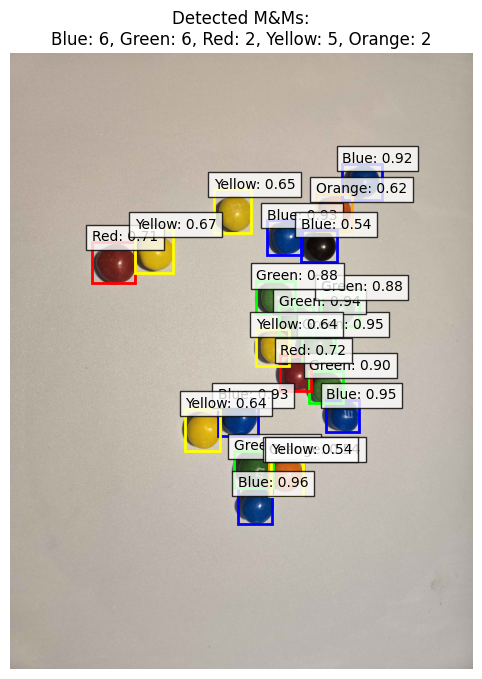


Detection Results:
Blue M&Ms: 6
Green M&Ms: 6
Red M&Ms: 2
Yellow M&Ms: 5
Orange M&Ms: 2

Total M&Ms detected: 21


In [1]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

class MMPredictor:
    def __init__(self, model_path):
        # Color mapping
        self.colors = {
            1: ("Red", (255, 0, 0)),
            2: ("Blue", (0, 0, 255)),
            3: ("Green", (0, 255, 0)),
            4: ("Yellow", (255, 255, 0)),
            5: ("Brown", (165, 42, 42)),
            6: ("Orange", (255, 165, 0))
        }
        
        # Set up device
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print(f"Using device: {self.device}")
        
        # Load model
        self.model = self.load_model(model_path)
        if self.model is None:
            raise ValueError("Failed to load the model. Please check the error messages above.")
        self.model.to(self.device)
        self.model.eval()

    def load_model(self, model_path):
        try:
            # Initialize model with same architecture
            model = fasterrcnn_resnet50_fpn(pretrained=False)
            
            # Modify for number of classes (background + 6 colors)
            num_classes = 7
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
                in_features, num_classes)
            
            # Load trained weights
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            return model
        except PermissionError:
            print(f"Error: Permission denied when trying to load the model from {model_path}")
            print("Please check if you have the necessary permissions to access this file.")
            return None
        except FileNotFoundError:
            print(f"Error: The model file {model_path} was not found.")
            print("Please make sure you've provided the correct path to the model file.")
            return None
        except Exception as e:
            print(f"An unexpected error occurred while loading the model: {str(e)}")
            return None

    def predict_image(self, image_path, confidence_threshold=0.5, save_output=True):
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        img_tensor = F.to_tensor(image)
        
        # Make prediction
        with torch.no_grad():
            prediction = self.model([img_tensor.to(self.device)])
        
        # Get prediction details
        pred_boxes = prediction[0]['boxes'].cpu().numpy()
        pred_labels = prediction[0]['labels'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()
        
        # Convert image for display
        img_display = np.array(image)
        
        # Create figure
        plt.figure(figsize=(12, 8))
        plt.imshow(img_display)
        
        # Count M&Ms by color
        color_counts = {}
        
        # Draw predictions
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score > confidence_threshold:
                # Update color count
                color_name = self.colors[label][0]
                color_counts[color_name] = color_counts.get(color_name, 0) + 1
                
                # Draw box
                x1, y1, x2, y2 = box
                plt.gca().add_patch(plt.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    fill=False, color=np.array(self.colors[label][1])/255, linewidth=2
                ))
                
                # Add label
                plt.text(
                    x1, y1-5, 
                    f"{self.colors[label][0]}: {score:.2f}",
                    bbox=dict(facecolor='white', alpha=0.8)
                )
        
        # Add title with counts
        title = "Detected M&Ms:\n"
        for color, count in color_counts.items():
            title += f"{color}: {count}, "
        plt.title(title[:-2])  # Remove last comma and space
        
        plt.axis('off')
        
        # Save or show result
        if save_output:
            output_path = os.path.join(
                os.path.dirname(image_path),
                f"detected_{os.path.basename(image_path)}"
            )
            plt.savefig(output_path, bbox_inches='tight', dpi=300)
            print(f"Saved detection result to: {output_path}")
        
        plt.show()
        
        return color_counts

def main():
    # Get paths
    model_path = input("Enter path to trained model (mm_detector.pth): ")
    if not model_path:
        model_path = "mm_detector.pth"
    
    image_path = input("Enter path to image for prediction: ")
    
    try:
        # Create predictor
        predictor = MMPredictor(model_path)
        
        # Make prediction
        print("\nMaking prediction...")
        color_counts = predictor.predict_image(image_path)
        
        # Print results
        print("\nDetection Results:")
        total_mms = 0
        for color, count in color_counts.items():
            print(f"{color} M&Ms: {count}")
            total_mms += count
        print(f"\nTotal M&Ms detected: {total_mms}")
    except ValueError as e:
        print(f"Error: {str(e)}")
    except FileNotFoundError:
        print(f"Error: The image file {image_path} was not found.")
        print("Please make sure you've provided the correct path to the image file.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()


**Annotation tool**<br>
You can use this tool to fit/create your own model.<br>
This annotation tool labels some images for the model to be trained on.

In [ ]:
import cv2
import numpy as np
import json
import os
from pathlib import Path

class AnnotationTool:
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.images = []
        self.current_image = None
        self.current_image_name = ""
        self.current_boxes = []  # Will store [x1, y1, x2, y2, color_id]
        self.current_color = 1
        self.drawing = False
        self.start_point = None
        self.all_annotations = {}
        self.scale_factor = 1.0
        self.target_height = 800  # Maximum window height
        self.target_width = 1200  # Maximum window width
        
        # Define M&M colors and their IDs
        self.colors = {
            1: ("Red", (35, 36, 138)),
            2: ("Blue", (135, 72, 0)),
            3: ("Green", (43, 117, 60)),
            4: ("Yellow", (0, 179, 226)),
            5: ("Brown", (18, 23, 29)),
            6: ("Orange", (30, 98, 229))
        }
        
        # Load all images from folder
        self.load_images()
        self.current_idx = 0
        if self.images:
            self.load_current_image()

    def resize_image(self, image):
        """Resize image to fit screen while maintaining aspect ratio"""
        height, width = image.shape[:2]
        
        # Calculate scaling factor
        h_scale = self.target_height / height
        w_scale = self.target_width / width
        self.scale_factor = min(h_scale, w_scale)
        
        if self.scale_factor < 1:  # Only resize if image is too large
            new_width = int(width * self.scale_factor)
            new_height = int(height * self.scale_factor)
            return cv2.resize(image, (new_width, new_height))
        else:
            self.scale_factor = 1.0
            return image

    def scale_to_original(self, x, y):
        """Convert display coordinates to original image coordinates"""
        return int(x / self.scale_factor), int(y / self.scale_factor)

    def scale_to_display(self, x, y):
        """Convert original image coordinates to display coordinates"""
        return int(x * self.scale_factor), int(y * self.scale_factor)
    
    def load_images(self):
        """Load all images from the specified folder"""
        valid_extensions = ['.jpg', '.jpeg', '.png']
        self.images = [f for f in os.listdir(self.image_folder) 
                      if any(f.lower().endswith(ext) for ext in valid_extensions)]
        self.images.sort()
    
    def load_current_image(self):
        """Load the current image and any existing annotations"""
        if 0 <= self.current_idx < len(self.images):
            self.current_image_name = self.images[self.current_idx]
            img_path = os.path.join(self.image_folder, self.current_image_name)
            original_image = cv2.imread(img_path)
            self.current_image = self.resize_image(original_image)
            self.current_boxes = []
            
            # Load existing annotations if any
            if self.current_image_name in self.all_annotations:
                self.current_boxes = self.all_annotations[self.current_image_name]['boxes']
    
    def draw_color_selector(self, img):
        """Draw color selector menu at the top of the image"""
        padding = 10
        for color_id, (color_name, bgr) in self.colors.items():
            # Draw color box
            cv2.rectangle(img, (padding, 10), (padding + 30, 40), bgr, -1)
            # Add color number
            cv2.putText(img, str(color_id), (padding + 10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            # Highlight selected color
            if color_id == self.current_color:
                cv2.rectangle(img, (padding - 2, 8), (padding + 32, 42), (255, 255, 255), 2)
            padding += 50
        
        # Display current color name
        cv2.putText(img, f"Selected: {self.colors[self.current_color][0]}", 
                   (padding + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events for drawing boxes"""
        if event == cv2.EVENT_LBUTTONDOWN:
            self.drawing = True
            self.start_point = (x, y)
        
        elif event == cv2.EVENT_MOUSEMOVE and self.drawing:
            img_copy = self.current_image.copy()
            # Draw all existing boxes
            self.draw_boxes(img_copy)
            # Draw current box
            cv2.rectangle(img_copy, self.start_point, (x, y), 
                         self.colors[self.current_color][1], 2)
            self.draw_color_selector(img_copy)
            cv2.imshow('Annotation Tool', img_copy)
        
        elif event == cv2.EVENT_LBUTTONUP:
            self.drawing = False
            # Convert display coordinates to original image coordinates
            x1, y1 = self.scale_to_original(*self.start_point)
            x2, y2 = self.scale_to_original(x, y)
            
            # Ensure coordinates are in correct order
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            
            # Add new box with original image coordinates
            self.current_boxes.append([x1, y1, x2, y2, self.current_color])
            
            # Update display
            img_copy = self.current_image.copy()
            self.draw_boxes(img_copy)
            self.draw_color_selector(img_copy)
            cv2.imshow('Annotation Tool', img_copy)

    def draw_boxes(self, img):
        """Draw all boxes on the image"""
        for box in self.current_boxes:
            # Convert original coordinates to display coordinates
            x1, y1 = self.scale_to_display(box[0], box[1])
            x2, y2 = self.scale_to_display(box[2], box[3])
            color_id = box[4]
            cv2.rectangle(img, (x1, y1), (x2, y2), self.colors[color_id][1], 2)
    
    def run(self):
        """Run the annotation tool"""
        if not self.images:
            print("No images found in the specified folder!")
            return
        
        print("\nControls:")
        print("1-6: Select M&M color")
        print("n: Next image")
        print("p: Previous image")
        print("u: Undo last box")
        print("s: Save annotations")
        print("q: Quit and save")
        
        cv2.namedWindow('Annotation Tool')
        cv2.setMouseCallback('Annotation Tool', self.mouse_callback)
        
        while True:
            img_copy = self.current_image.copy()
            self.draw_boxes(img_copy)
            self.draw_color_selector(img_copy)
            cv2.imshow('Annotation Tool', img_copy)
            key = cv2.waitKey(1) & 0xFF
            
            # Color selection
            if ord('1') <= key <= ord('6'):
                self.current_color = key - ord('0')
            
            elif key == ord('n'):  # Next image
                self.save_current_annotations()
                self.current_idx = min(self.current_idx + 1, len(self.images) - 1)
                self.load_current_image()
            
            elif key == ord('p'):  # Previous image
                self.save_current_annotations()
                self.current_idx = max(self.current_idx - 1, 0)
                self.load_current_image()
            
            elif key == ord('u'):  # Undo last box
                if self.current_boxes:
                    self.current_boxes.pop()
            
            elif key == ord('s'):  # Save annotations
                self.save_current_annotations()
                self.save_all_annotations()
                print("Annotations saved!")
            
            elif key == ord('q'):  # Quit
                self.save_current_annotations()
                self.save_all_annotations()
                break
        
        cv2.destroyAllWindows()
    
    def save_current_annotations(self):
        """Save annotations for current image"""
        # Save original coordinates
        boxes = [[box[0], box[1], box[2], box[3]] for box in self.current_boxes]
        labels = [box[4] for box in self.current_boxes]
        self.all_annotations[self.current_image_name] = {
            'boxes': boxes,
            'labels': labels
        }
    
    def save_all_annotations(self):
        """Save all annotations to a JSON file"""
        output_path = os.path.join(self.image_folder, 'annotations.json')
        with open(output_path, 'w') as f:
            json.dump(self.all_annotations, f, indent=4)
    
    def get_training_format(self):
        """Convert annotations to training format"""
        img_paths = []
        annotations = []
        
        for img_name, anno in self.all_annotations.items():
            img_paths.append(os.path.join(self.image_folder, img_name))
            annotations.append({
                'boxes': anno['boxes'],
                'labels': anno['labels']
            })
        
        return img_paths, annotations

def main():
    """Main function to run the annotation tool"""
    folder_path = input("Enter the folder path containing your M&M images: ")
    tool = AnnotationTool(folder_path)
    tool.run()
    
    # Get annotations in training format
    img_paths, annotations = tool.get_training_format()
    print(f"\nAnnotated {len(img_paths)} images")
    
    # Print color statistics
    color_counts = {}
    for anno in annotations:
        for label in anno['labels']:
            color_counts[label] = color_counts.get(label, 0) + 1
    
    print("\nM&M counts by color:")
    for color_id, count in color_counts.items():
        color_name = tool.colors[color_id][0]
        print(f"{color_name}: {count}")

if __name__ == "__main__":
    main()

**r-CNN code**<br>
This code segment fits rCNN to the annotation.json using transfer learning.

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os

class ColoredMMDataset(Dataset):
    def __init__(self, image_folder, annotation_file):
        self.image_folder = image_folder
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Get list of image files that have annotations
        self.image_files = list(self.annotations.keys())
        
        # Color mapping for visualization
        self.colors = {
            1: "Red",
            2: "Blue",
            3: "Green",
            4: "Yellow",
            5: "Brown",
            6: "Orange"
        }

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_filename)
        img = Image.open(img_path).convert("RGB")
        
        # Convert image to tensor
        img_tensor = F.to_tensor(img)
        
        # Get annotations for this image
        anno = self.annotations[img_filename]
        
        # Convert annotations to tensor format
        boxes = torch.as_tensor(anno['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(anno['labels'], dtype=torch.int64)
        
        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return img_tensor, target

    def __len__(self):
        return len(self.image_files)

def get_model(num_classes):
    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Modify the box predictor for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    
    return model

def train_model(model, data_loader, device, num_epochs=10):
    # Move model to device
    model.to(device)
    
    # Initialize optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for images, targets in data_loader:
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            total_loss += losses.item()
        
        # Print epoch statistics
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return model

def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    
    plt.figure(figsize=(15, 3*num_samples))
    
    for i in range(min(num_samples, len(dataset))):
        # Get image and target
        img, target = dataset[i]
        
        # Make prediction
        with torch.no_grad():
            prediction = model([img.to(device)])
        
        # Convert image for display
        img_display = img.permute(1, 2, 0).cpu().numpy()
        
        # Plot original image with ground truth
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_display)
        
        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.numpy()
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                            fill=False, color='green', linewidth=2))
            plt.text(x1, y1, dataset.colors[label.item()],
                    bbox=dict(facecolor='white', alpha=0.8))
        
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Plot predictions
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img_display)
        
        pred_boxes = prediction[0]['boxes'].cpu().numpy()
        pred_labels = prediction[0]['labels'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()
        
        # Only show predictions with score > 0.5
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score > 0.5:
                x1, y1, x2, y2 = box
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                fill=False, color='red', linewidth=2))
                plt.text(x1, y1, f"{dataset.colors[label]}\n{score:.2f}",
                        bbox=dict(facecolor='white', alpha=0.8))
        
        plt.title('Predictions')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    # Set device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")
    
    # Get data paths
    image_folder = input("Enter the folder path containing your M&M images: ")
    annotation_file = os.path.join(image_folder, 'annotations.json')
    
    # Create dataset
    dataset = ColoredMMDataset(image_folder, annotation_file)
    
    # Split dataset into train and validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )
    
    # Initialize model
    num_classes = 7  # Background + 6 M&M colors
    model = get_model(num_classes)
    
    # Train model
    model = train_model(model, train_loader, device)
    
    # Save the trained model
    torch.save(model.state_dict(), os.path.join(image_folder, 'mm_detector.pth'))
    
    # Visualize some predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, val_dataset, device)
    
    print("\nTraining completed! Model saved as 'mm_detector.pth'")

if __name__ == "__main__":
    main()